In [15]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

from mask_functions import rle2mask
import pydicom

In [81]:
im_height = 1024
im_width = 1024
im_chan = 1

class SIMMDataset(Dataset):
    """SIMM dataset."""

    def __init__(self, dicomPaths, mask_csv_file, transform=None):
        """
        Args:
            dicomPaths (Array<string>): Array of DICOM file Paths.
            mask_csv_file (string): csv file with encoded masks (rle).
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.encodedMasks = pd.read_csv(mask_csv_file, names=['ImageId', 'EncodedPixels'], index_col='ImageId')
        self.dicomPaths = dicomPaths
        self.transform = transform

    def __len__(self):
        return len(self.dicomPaths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        dPath = self.dicomPaths[idx]
        dicom = pydicom.dcmread(dPath)
        
#         image = np.zeros((1, im_height, im_width, im_chan), dtype=np.uint8)
#         image = np.expand_dims(dicom.pixel_array, axis=2)
        image = np.array(dicom.pixel_array)
        
        # get mask (in rle) from csv
        landmarks = np.zeros((im_height, im_width), dtype=np.bool)
        
        fileId = dPath.split('/')[-1][:-4]
        rle = self.encodedMasks.loc[fileId, 'EncodedPixels']
        try:
            if type(rle) == str: # if single rle
                decodedRle = rle2mask(rle, im_height, im_width)
#                 landmarks = np.expand_dims(decodedRle, axis=2)
                landmarks = decodedRle
            else: # if multiple rle
                for x in rle:
                    decodedRle = rle2mask(x, im_height, im_width)
                    landmarks = landmarks + decodedRle
#                     landmarks = landmarks + np.expand_dims(decodedRle, axis=2)
        except Exception as e:
            print(e)
            
        #### TODO - IMPORTANT::: CHECK THIS  
        ## QUESTION: SHOULD WE TRANSPOSE THE MASK IN THE GETITEM FUNCTION 
        ## BECASUE WHEN PLOTING THE GRAPHS WE HAVE TO TRANSPOSE IT.
        landmarks = landmarks.T
            
        sample = {'image': image, 'mask': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample['image'], sample['mask']


In [17]:
filePathsCsv = './input/siim/dataset-with-masks-rle.csv'
endcodedMasksCsv = './input/siim/train-rle.csv'

In [18]:
filePaths = pd.read_csv(filePathsCsv)
filePaths = filePaths['path'].tolist()
filePaths[0]

'./input/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10224.1517875222.707890/1.2.276.0.7230010.3.1.3.8323329.10224.1517875222.707889/1.2.276.0.7230010.3.1.4.8323329.10224.1517875222.707891.dcm'

In [82]:
dataset = SIMMDataset(dicomPaths=filePaths, mask_csv_file=endcodedMasksCsv)

0 (1024, 1024) (1024, 1024)
1 (1024, 1024) (1024, 1024)
2 (1024, 1024) (1024, 1024)
3 (1024, 1024) (1024, 1024)
4 (1024, 1024) (1024, 1024)


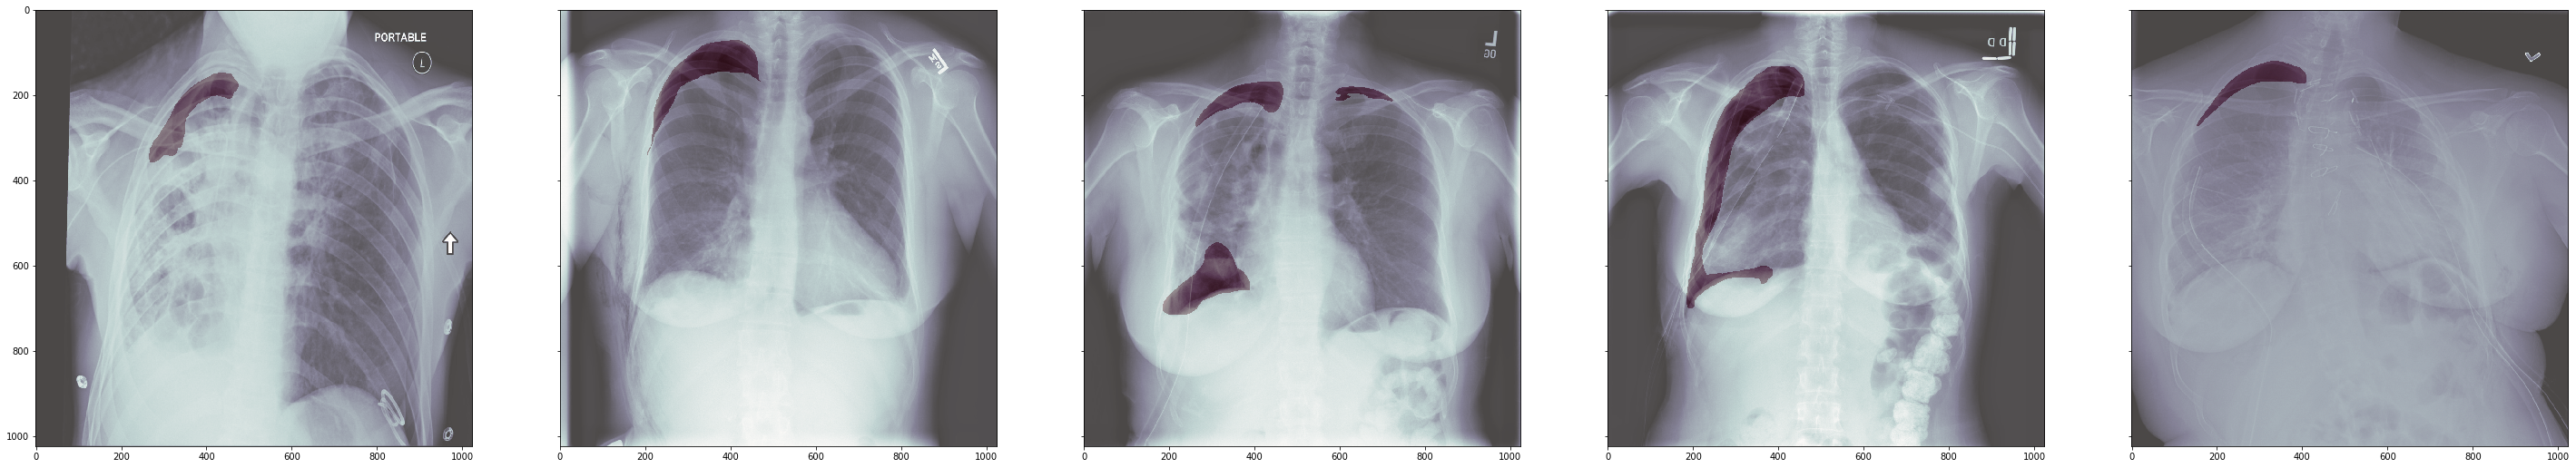

In [83]:
num_img = 5

fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))    
for i in range(len(dataset)):
    image, mask = dataset[i]

    print(i, image.shape, mask.shape)
    
    ax[i].imshow(image, cmap=plt.cm.bone)
    ax[i].imshow(mask, alpha=0.3, cmap="Reds")

    if i == num_img - 1:
        break

In [88]:
trainloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        print(inputs.size())
        print(labels.size())
        break
    break
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, landmarks = data
#         print(i, inputs.shape, landmarks.shape)

    

print('Finished Training')

torch.Size([4, 1024, 1024])
torch.Size([4, 1024, 1024])
Finished Training
